<a href="https://colab.research.google.com/github/prof-rossetti/intro-to-python/blob/main/notebooks/applied-ds/Appled_Statistics_for_Finance_Basic_Statistics_and_Correlation_(Summer_2023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's fetch historical data about various economic and financial indicators, to help us illustrate basic statistical concepts and techniques in Python.

After setting a foundation for basic statistical concepts and showing examples of how to perform some statistical tests, we will focus on correlation, and determining which of these indicators may be positively or negatively correlated with eachother. This will allow us, for example, to answer the question, "is gold a good hedge against inflation?".

## Fetching Data

Let's grab lots of different economic and market indicators from the AlphaVantage API, and prepare each source dataset in such a way that allows it to be merged with the others later.

First, obtain an [AlphaVantage API Key](https://www.alphavantage.co/support/#api-key), or use one of the prof's "premium" keys. And supply it below:

In [48]:
from getpass import getpass

API_KEY = getpass("Please input your AlphaVantage API Key: ")

Please input your AlphaVantage API Key: ··········


### Inflation

https://www.alphavantage.co/documentation/#inflation

In [49]:
#from pandas import read_csv
#
#request_url = f"https://www.alphavantage.co/query?function=INFLATION&apikey={API_KEY}&datatype=csv"
#inflation = read_csv(request_url)
#inflation.head()

Here we have annual data. Doesn't look like the endpoint provides more frequent intervals. So let's not use this.

### Consumer Price Index (CPI)

https://www.alphavantage.co/documentation/#cpi

> CPI is widely regarded as the barometer of inflation levels in the broader economy.

The CPI endpoint does provide access to monthly data. So let's use CPI as our desired measure of inflation.

In [50]:
from pandas import read_csv

request_url = f"https://www.alphavantage.co/query?function=CPI&interval=monthly&apikey={API_KEY}&datatype=csv"
cpi_df = read_csv(request_url)
cpi_df.rename(columns={"value": "cpi"}, inplace=True)
cpi_df.head()

,timestamp,cpi
0,2023-05-01,304.127
1,2023-04-01,303.363
2,2023-03-01,301.836
3,2023-02-01,300.840
4,2023-01-01,299.170


In [51]:
print("EARLIEST:", cpi_df.iloc[-1]["timestamp"])

EARLIEST: 1913-01-01


In [52]:
import plotly.express as px

px.line(cpi_df, x="timestamp", y="cpi", title="Consumer Price Index (CPI) by Month", height=350)

### Federal Funds Rate

https://www.alphavantage.co/documentation/#interest-rate

In [53]:
request_url = f"https://www.alphavantage.co/query?function=FEDERAL_FUNDS_RATE&interval=monthly&apikey={API_KEY}&datatype=csv"
fed_funds_df = read_csv(request_url)
fed_funds_df.rename(columns={"value": "fed"}, inplace=True)
fed_funds_df.head()

,timestamp,fed
0,2023-05-01,5.06
1,2023-04-01,4.83
2,2023-03-01,4.65
3,2023-02-01,4.57
4,2023-01-01,4.33


In [54]:
print("EARLIEST:", fed_funds_df["timestamp"].min())

EARLIEST: 1954-07-01


In [55]:
import plotly.express as px

px.line(fed_funds_df, x="timestamp", y="fed", title="Federal Funds Rate by Month", height=350)

### The Market (S&P 500)




https://www.investopedia.com/articles/investing/122215/spy-spdr-sp-500-trust-etf.asp

> The SPDR S&P 500 ETF Trust is one of the most popular funds. It aims to track the Standard & Poor's (S&P) 500 Index, which comprises 500 large-cap U.S. stocks. These stocks are selected by a committee based on market size, liquidity, and industry. The S&P 500 serves as one of the main benchmarks of the U.S. equity market and indicates the financial health and stability of the economy


https://www.alphavantage.co/documentation/#monthlyadj

We can use the "SPY" ETF as a measure of the market. Looks like the data only covers the past 20 years (see endpoint docs).


In [56]:
from pandas import read_csv

request_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol=SPY&apikey={API_KEY}&datatype=csv"
spy_df = read_csv(request_url)
spy_df.drop(columns=["open", "high", "low", "close", "volume", "dividend amount"], inplace=True)
spy_df.rename(columns={"adjusted close": "spy"}, inplace=True)
spy_df.head()

,timestamp,spy
0,2023-06-27,436.1700
1,2023-05-31,416.2980
2,2023-04-28,414.3851
3,2023-03-31,407.8694
4,2023-02-28,393.2693


In [57]:
print("ROWS:", len(spy_df))
print("EARLIEST:", spy_df["timestamp"].min())

ROWS: 283
EARLIEST: 1999-12-31


In [58]:
## standardizing the timestamp values so we can merge on them later
## we have to decide to treat "2023-05-31" as "2023-05" or "2023-06"
## since we see the latest value represents the current incompleted month,
## let's "round down" the monthly values
#
#from pandas import to_datetime
#
#spy_df["timestamp"] = to_datetime(spy_df["timestamp"]).dt.strftime("%Y-%m-01")
#spy_df.head()

In [59]:
from pandas import to_datetime

# packaging up this code into a reusable function becuse we'll have to perform this same operation on multiple datasets (see cells below related to gold and bitcoin)

def round_down_monthly_timestamp(original_df):
    """ Param original_df: pandas DataFrame that has a "timestamp" column of values representing each month"""
    # standardizing the timestamp values so we can merge on them later
    # we have to decide to treat "2023-05-31" as "2023-05-01" or "2023-06-01"
    # since we see the latest value represents the current incompleted month,
    # let's "round down" the monthly values
    # see: https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
    original_df["timestamp"] = to_datetime(original_df["timestamp"]).dt.strftime("%Y-%m-01")


round_down_monthly_timestamp(spy_df)
spy_df.head()

,timestamp,spy
0,2023-06-01,436.1700
1,2023-05-01,416.2980
2,2023-04-01,414.3851
3,2023-03-01,407.8694
4,2023-02-01,393.2693


In [60]:
import plotly.express as px

px.line(spy_df, x="timestamp", y="spy", title="S&P 500 (SPY ETF) Prices by Month", height=350)

### Gold

https://www.investopedia.com/articles/investing/122515/gld-ishares-gold-trust-etf.asp

> The SPDR Gold Shares ETF (GLD) tracks the price of gold bullion in the over-the-counter (OTC) market.

https://money.usnews.com/investing/funds/slideshows/best-gold-etfs-to-hedge-volatility

> The largest gold exchange-traded fund, or ETF, by a wide margin is the SPDR Gold Trust... And as the fund is benchmarked to physical gold, you can get a direct play on gold bullion prices via this ETF.

OK we can perhaps use the "GLD" index fund as a measure of gold prices.

In [61]:
from pandas import read_csv

request_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY_ADJUSTED&symbol=GLD&apikey={API_KEY}&datatype=csv"
gld_df = read_csv(request_url)
gld_df.drop(columns=["open", "high", "low", "close", "volume", "dividend amount"], inplace=True)
gld_df.rename(columns={"adjusted close": "gld"}, inplace=True)
gld_df.head()

,timestamp,gld
0,2023-06-27,177.69
1,2023-05-31,182.32
2,2023-04-28,184.80
3,2023-03-31,183.22
4,2023-02-28,169.78


In [62]:
print("ROWS:", len(gld_df))
print("EARLIEST:", gld_df["timestamp"].min())

ROWS: 223
EARLIEST: 2004-12-31


In [63]:
round_down_monthly_timestamp(gld_df)
gld_df.head()

,timestamp,gld
0,2023-06-01,177.69
1,2023-05-01,182.32
2,2023-04-01,184.80
3,2023-03-01,183.22
4,2023-02-01,169.78


In [64]:
import plotly.express as px

px.line(gld_df, x="timestamp", y="gld", title="Gold (GLD ETF) Prices by Month", height=350)

### Bitcoin

https://www.alphavantage.co/documentation/#currency-monthly



The earliest Bitcoin data we have is from 2020.

In [65]:
request_url = f"https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_MONTHLY&symbol=BTC&market=USD&apikey={API_KEY}&datatype=csv"
btc_df = read_csv(request_url)
btc_df = btc_df[["timestamp", "close (USD)"]]
btc_df.rename(columns={"close (USD)": "btc"}, inplace=True)
btc_df.head()

,timestamp,btc
0,2023-06-28,30515.49
1,2023-05-31,27210.35
2,2023-04-30,29233.21
3,2023-03-31,28465.36
4,2023-02-28,23141.57


In [66]:
print("ROWS:", len(btc_df))
print("EARLIEST:", btc_df["timestamp"].min())

ROWS: 32
EARLIEST: 2020-11-30


In [67]:
round_down_monthly_timestamp(btc_df)
btc_df.head()

,timestamp,btc
0,2023-06-01,30515.49
1,2023-05-01,27210.35
2,2023-04-01,29233.21
3,2023-03-01,28465.36
4,2023-02-01,23141.57


In [68]:
import plotly.express as px

px.line(btc_df, x="timestamp", y="btc", title="Bitcoin Prices by Month, in USD", height=350)

## Merging Data

Let's merge all datasets together, on the basis of their common date values (i.e. the "timestamp" column common across all datasets).

In [69]:
print(cpi_df.columns.tolist())
print(fed_funds_df.columns.tolist())
print(spy_df.columns.tolist())
print(gld_df.columns.tolist())
print(btc_df.columns.tolist())

['timestamp', 'cpi']
['timestamp', 'fed']
['timestamp', 'spy']
['timestamp', 'gld']
['timestamp', 'btc']


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html


We use a precise merge on matching timestamp values, instead of making assumptions about the row frequency and order of source datasets. In this way, the merge operation is similar to a `VLOOKUP` operation in spreadsheet software.

You'll notice we have been renaming the columns in the source datasets, and ensuring their "timestamp" values are represented in a standardized way (i.e. all at the beginning of month), to facilitate a clean merge on these common values.

We do an "inner" join strategy, to only keep the rows that have matching timestamp values across all datasets.

So the resulting merged dataset starts in 2020, because that is the earliest data available across ALL datasets (as constrained by the Bitcoin dataset). For analyses that only involve two of these indicators, it may be worth it to create a separate merged dataset from only those two (not including Bitcoin), to obtain as much historical context as possible.

In [70]:
df = cpi_df.merge(fed_funds_df, on="timestamp", how="inner")
df = df.merge(spy_df, on="timestamp", how="inner")
df = df.merge(gld_df, on="timestamp", how="inner")
df = df.merge(btc_df, on="timestamp", how="inner")
df.index = df["timestamp"]
df.tail()

,timestamp,cpi,fed,spy,gld,btc
timestamp,,,,,,
2021-03-01,2021-03-01,264.877,0.07,383.1577,159.96,58740.55
2021-02-01,2021-02-01,263.014,0.08,366.5160,161.81,45135.66
2021-01-01,2021-01-01,261.582,0.09,356.6006,172.61,33092.98
2020-12-01,2020-12-01,260.474,0.09,360.2719,178.36,28923.63
2020-11-01,2020-11-01,260.229,0.09,347.3953,166.67,19695.87


Now that we have a single merged dataset, let's use it to illustrate some basic statistical concepts and techniques.


## Basic Summary Statistics

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

We can use the describe method to quickly see the basic summary statistics for each column:

In [71]:
df.describe()

,cpi,fed,spy,gld,btc
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,283.662419,1.444516,403.450923,169.789677,34744.694194
std,14.621292,1.854777,29.854243,8.247327,13352.109261
min,260.229000,0.060000,347.395300,151.910000,16542.400000
25%,272.349500,0.080000,382.339800,165.155000,23133.350000
50%,283.716000,0.100000,404.492200,169.640000,33092.980000
75%,296.802500,2.820000,421.470650,177.635000,44479.880000
max,304.127000,5.060000,463.829300,184.800000,61299.800000


Although as you may be aware, we can calculate these individually using series aggregations:

In [72]:
# https://pandas.pydata.org/docs/reference/api/pandas.Series.html
# https://pandas.pydata.org/docs/reference/api/pandas.Series.quantile.html

series = df["fed"]

print("COUNT:", len(series))
print("MEAN:", series.mean())
print("STD:", series.std())
print("MIN:", series.min())
print("25TH PERCENTILE:", series.quantile(.25))
print("75TH PERCENTILE:", series.quantile(.75))
print("MAX:", series.max())

COUNT: 31
MEAN: 1.4445161290322586
STD: 1.854777324837454
MIN: 0.06
25TH PERCENTILE: 0.08
75TH PERCENTILE: 2.8200000000000003
MAX: 5.06


In [73]:
series.describe() # for comparison

count    31.000000
mean      1.444516
std       1.854777
min       0.060000
25%       0.080000
50%       0.100000
75%       2.820000
max       5.060000
Name: fed, dtype: float64

Let's view some distribution plots of the federal funds rate, to tell a story about the summary statistics for this indicator.

In [74]:
import plotly.express as px

px.box(df, x="fed", orientation="h", points="all", title="Distribution of Federal Funds Rate (Monthly)", hover_data=["timestamp"],)

In [75]:
# https://plotly.com/python-api-reference/generated/plotly.express.violin.html
import plotly.express as px

#px.violin(df, y="fed", points="all", box=True, title="Distribution of Federal Funds Rate (Monthly)", hover_data=["timestamp"])
px.violin(df, x="fed", orientation="h", points="all", box=True, title="Distribution of Federal Funds Rate (Monthly)", hover_data=["timestamp"])

In [76]:
# https://plotly.com/python-api-reference/generated/plotly.express.histogram.html
px.histogram(df, x="fed", #nbins=12,
        title="Distribution of Federal Funds Rate (Monthly)", height=350)

Looks like the recent higher funds rates are potential outliers. It is hard to say for sure if this data is normally distributed, or whether it is too skewed by the outliers.

## Statistical Tests with `Scipy`


We can use the Scipy package to perform basic statistical tests.

https://pypi.org/project/scipy/


### Normality Tests

We can conduct a normality test to see if a given distribution is normally distributed.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html

> This function tests the null hypothesis that a sample comes from a normal distribution.
>
> If the p-value is "small" - that is, if there is a low probability of sampling data from a normally distributed population that produces such an extreme value of the statistic - this may be taken as evidence against the null hypothesis in favor of the alternative: the weights were not drawn from a normal distribution.

In [77]:
from scipy.stats import normaltest

x = df["fed"]

result = normaltest(x)
print(result)

NormaltestResult(statistic=6.341011055171527, pvalue=0.041982369292280414)


Interpreting the results.

https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistics/basic-statistics/how-to/normality-test/interpret-the-results/key-results/

> To determine whether the data do not follow a normal distribution, compare the p-value to the significance level. Usually, a significance level (denoted as α or alpha) of 0.05 works well. A significance level of 0.05 indicates a 5% risk of concluding that the data do not follow a normal distribution when the data do follow a normal distribution.
>
> P-value ≤ α: The data do not follow a normal distribution (Reject H0)
> If the p-value is less than or equal to the significance level, the decision is to reject the null hypothesis and conclude that your data do not follow a normal distribution.
>
> P-value > α: You cannot conclude that the data do not follow a normal distribution (Fail to reject H0). If the p-value is larger than the significance level, the decision is to fail to reject the null hypothesis. You do not have enough evidence to conclude that your data do not follow a normal distribution.

In [78]:
if result.pvalue <= 0.05:
    print("REJECT (NOT NORMAL)")
else:
    print("NOT ABLE TO REJECT (COULD BE NORMAL)")

REJECT (NOT NORMAL)


Looks like the federal fuds rate does not have a normal distribution. Although it is possible the market does:

In [79]:

x = df["spy"]

result = normaltest(x)
print(result)

if result.pvalue <= 0.05:
    print("REJECT (NOT NORMAL)")
else:
    print("NOT ABLE TO REJECT (COULD BE NORMAL)")

NormaltestResult(statistic=0.5091680510832584, pvalue=0.7752389104846413)
NOT ABLE TO REJECT (COULD BE NORMAL)


### T-Tests


https://www.investopedia.com/terms/t/t-test.asp

> A t-test is an inferential statistic used to determine if there is a significant difference between the means of two groups and how they are related. T-tests are used when the data sets follow a normal distribution and have unknown variances, like the data set recorded from flipping a coin 100 times.

### T-Test Considerations

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6676026/#sec-2title

In order to conduct a T-Test, the data needs to be normally distributed. So the examples below may not be the most methodologically sound. However they should provide code examples you can adapt for other use cases in the future.

#### 2 Sample T-Test

A two sample T-test is used to determine whether two independent samples come from the same distribution.


Let's split the most recent year's rates from the rest. And see if the most recent years are statistically different.

In [80]:

#cutoff_date = "2022-06-01" # you can chose a different one if you'd like
cutoff_date = "2022-10-01"

rates_recent = df[df["timestamp"] >= cutoff_date]["fed"]
print(len(rates_recent))
print(rates_recent)

print("----------------")

rates_historic = df[df["timestamp"] < cutoff_date]["fed"]
print(len(rates_historic))
print(rates_historic)


8
timestamp
2023-05-01    5.06
2023-04-01    4.83
2023-03-01    4.65
2023-02-01    4.57
2023-01-01    4.33
2022-12-01    4.10
2022-11-01    3.78
2022-10-01    3.08
Name: fed, dtype: float64
----------------
23
timestamp
2022-09-01    2.56
2022-08-01    2.33
2022-07-01    1.68
2022-06-01    1.21
2022-05-01    0.77
2022-04-01    0.33
2022-03-01    0.20
2022-02-01    0.08
2022-01-01    0.08
2021-12-01    0.08
2021-11-01    0.08
2021-10-01    0.08
2021-09-01    0.08
2021-08-01    0.09
2021-07-01    0.10
2021-06-01    0.08
2021-05-01    0.06
2021-04-01    0.07
2021-03-01    0.07
2021-02-01    0.08
2021-01-01    0.09
2020-12-01    0.09
2020-11-01    0.09
Name: fed, dtype: float64


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

> Calculate the T-test for the means of two independent samples of scores.
>
> This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.
>
> The t-test quantifies the difference between the arithmetic means of the two samples. The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true. A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means.

In [81]:
print(rates_recent.var())
print(rates_historic.var())

0.4076571428571429
0.5651482213438738


In [82]:
from scipy.stats import ttest_ind

result = ttest_ind(rates_recent, rates_historic)
print(result)

if result.pvalue <= 0.05:
    print("REJECT (MEANS NOT THE SAME)")
else:
    print("NOT ABLE TO REJECT (MEANS COULD BE THE SAME)")

Ttest_indResult(statistic=12.91461536971339, pvalue=1.4903884740858837e-13)
REJECT (MEANS NOT THE SAME)


#### 1 Sample T-Test

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html


> Calculate the T-test for the mean of ONE group of scores.
>
> This is a test for the null hypothesis that the expected value (mean) of a sample of independent observations a is equal to the given population mean, popmean.
>
> Under certain assumptions about the population from which a sample is drawn, the confidence interval with confidence level 95% is expected to contain the true population mean in 95% of sample replications.

Suppose we wish to test the null hypothesis that the mean of the fed funds rates is equal to 2.5%.


In [83]:
from scipy.stats import ttest_1samp

x = df["fed"]
print(x.mean())

popmean = 2.5 # for example
result = ttest_1samp(x, popmean=popmean)
print(result)

if result.pvalue <= 0.05:
    print("REJECT (MEAN NOT EQUAL TO POPMEAN)")
else:
    print("NOT ABLE TO REJECT (MEAN COULT BE EQUAL TO POPMEAN)")

ci = result.confidence_interval(confidence_level=0.95)
print(ci)

1.4445161290322586
TtestResult(statistic=-3.1684048557317164, pvalue=0.003512833565631727, df=30)
REJECT (MEAN NOT EQUAL TO POPMEAN)
ConfidenceInterval(low=0.7641783136649692, high=2.124853944399548)


## Correlation



OK let's take a step back though. The primary reason why we fetched all these different datasets and merged them together, is so we can explore the correlation between them.

Correlation is a measure of how two datasets are related to eachother.


https://www.investopedia.com/terms/c/correlation.asp

<img src="https://www.investopedia.com/thmb/Xz1Mnf7Ji54AAfAT1fsiwcZvmxM=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/correlation_defintion_-9d2d662781724d61af6d6322a2a294b5.jpg" height=250>


> Investment managers, traders, and analysts find it very important to calculate correlation because the risk reduction benefits of diversification rely on this statistic.

Let's take a quick detour to make a scaled version of this data, to make it easier to plot all these different series on a graph, so we can perhaps start to get a sense of how their movements might correlate (in an unofficial way).

In [84]:
scaled_df = df.copy()
scaled_df.index = df["timestamp"] # save the ts for charting, knowing we will remove it
scaled_df.drop(columns=["timestamp"], inplace=True) # remove the ts column, in preparation to operate on all numeric columns
scaled_df = scaled_df / scaled_df.max() # dividing all numeric col values by their column's max. there are many alternative methods for scaling the data
scaled_df.head()

import plotly.express as px
px.line(scaled_df, y=["cpi", "fed", "spy", "gld", "btc"], title="Scaled data over time")

Looks like the federal funds rate has been moving up at a time when Bitcoin has been moving downward. We might start to suspect they are correlated in a negative way.

> NOTE: correlation does not imply causation!

Let's now perform tests for correlation in more official / formal ways.



### Correlation Considerations

Certain methods for calculating correlation may depend on the normality of our data's distribution, or the sample size, so we should keep these in mind as we determine if we are able to calculate correlation, and which method to use.



https://www.investopedia.com/terms/n/nonparametric-method.asp


> The nonparametric method refers to a type of statistic that does not make any assumptions about the characteristics of the sample (its parameters) or whether the observed data is quantitative or qualitative.
>
> Nonparametric statistics can include certain descriptive statistics, statistical models, inference, and statistical tests. The model structure of nonparametric methods is not specified a priori but is instead determined from data.
>
> Common nonparametric tests include Chi-Square, Wilcoxon rank-sum test, Kruskal-Wallis test, and Spearman's rank-order correlation.
>
> In contrast, well-known statistical methods such as ANOVA, Pearson's correlation, t-test, and others do make assumptions about the data being analyzed. One of the most common parametric assumptions is that population data have a "normal distribution."


### Correlation with `scipy`



We can always calculate correlation between two lists of numbers, using the `pearsonr` and `spearmanr` functions from the `scipy` package.

One difference between these two correlation methods is that Spearman is more robust to (i.e. less affected by) outliers. Also being nonparametric, the Spearman method does not assume our data is normally distributed.


https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

> Pearson correlation coefficient and p-value for testing non-correlation.
>
> The Pearson correlation coefficient [1] measures the linear relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
>
> This function also performs a test of the null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed. (See Kowalski [3] for a discussion of the effects of non-normality of the input on the distribution of the correlation coefficient.) The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html

> Calculate a Spearman correlation coefficient with associated p-value.
>
> The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
>
> The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Spearman correlation at least as extreme as the one computed from these datasets. Although calculation of the p-value does not make strong assumptions about the distributions underlying the samples, it is only accurate for very large samples (>500 observations). For smaller sample sizes, consider a permutation test instead (see docs for examples).

In [85]:
from scipy.stats import pearsonr

x = df["fed"]
y = df["btc"]

result = pearsonr(x, y)
print(result)

PearsonRResult(statistic=-0.6480585171866228, pvalue=8.084478872865406e-05)


In [86]:
from scipy.stats import spearmanr

x = df["fed"]
y = df["btc"]

result = spearmanr(x, y)
print(result)

SignificanceResult(statistic=-0.7361158368171475, pvalue=2.361914599466625e-06)


### Correlation Matrix with `pandas`

OK sure we can calculate correlation between two sets of data. But what if we wanted to calculate correlation between many different data sets? We could perhaps set up a loop, but there is an easier way.

If we have a pandas dataframe, we can use it's `corr()` method to produce a "correlation matrix", which shows us the "pairwise correlation of columns", in other words, the correlation of each column with respect to each other column.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html



In [91]:
#df.corr(method="pearson") # method is pearson by default
df.corr(method="pearson", numeric_only=True) # numeric_only to suppress warning

,cpi,fed,spy,gld,btc
cpi,1.000000,0.826044,0.103264,0.150411,-0.572872
fed,0.826044,1.000000,-0.157418,0.208205,-0.648059
spy,0.103264,-0.157418,1.000000,0.286905,0.554504
gld,0.150411,0.208205,0.286905,1.000000,0.007528
btc,-0.572872,-0.648059,0.554504,0.007528,1.000000


In [92]:
#df.corr(method="spearman")
df.corr(method="spearman", numeric_only=True) # numeric_only to suppress warning

,cpi,fed,spy,gld,btc
cpi,1.000000,0.840752,0.071774,0.206271,-0.530645
fed,0.840752,1.000000,-0.254872,0.254389,-0.736116
spy,0.071774,-0.254872,1.000000,0.291360,0.624597
gld,0.206271,0.254389,0.291360,1.000000,0.045569
btc,-0.530645,-0.736116,0.624597,0.045569,1.000000


We may begin to notice the diagonal of 1s values. This is because each dataset is perfectly positively correlated with itself.

We may also start to notice the symmetry of values mirrored across the diagonal. In other words, the value in column 1, row 4 is the same as the value in column 4, row 1.

### Plotting Correlation Matrix

It may not be easy to quickly interpret the rest of the values in the correlation matrix, but if we plot it with colors as a "heat map" then we will be able to use color to more easily interpret the data and tell a story.


Below are two generally equivalent plotting methods, using different packages. Choose whichever approach you prefer.

#### Correlation Heatmap with `plotly`

https://plotly.com/python-api-reference/generated/plotly.express.imshow.html

In [93]:
# https://plotly.com/python/heatmaps/
# https://plotly.com/python-api-reference/generated/plotly.express.imshow.html
import plotly.express as px

cor_mat = df.corr(method="spearman", numeric_only=True) # using numeric_only to suppress warning

title= "Spearman Correlation between Economic Indicators"
fig = px.imshow(cor_mat,
                height=600, # title=title,
                text_auto= ".2f", # round to two decimal places
                color_continuous_scale="Blues",
                color_continuous_midpoint=0, # set color midpoint at zero because correlation coeficient ranges from -1 to 1 (see correlation notes)
                labels={"x": "Indicator", "y": "Indicator"}
)
fig.update_layout(title={'text': title, 'x':0.485, 'xanchor': 'center'}) # https://stackoverflow.com/questions/64571789/center-plotly-title-by-default
fig.show()

#### Correlation Heatmap with `seaborn`

https://seaborn.pydata.org/generated/seaborn.heatmap.html

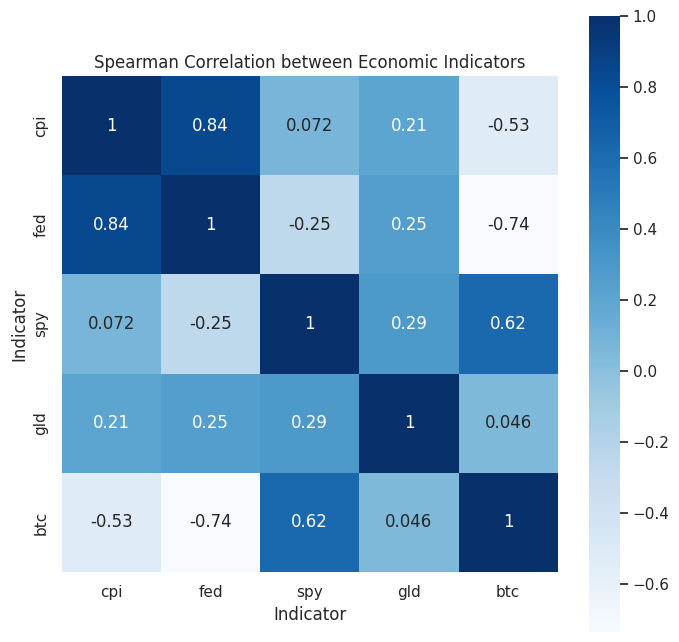

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_matrix(mat, title="Spearman Correlation between Economic Indicators", axis_label="Indicator", figsize=(8,8)):
    """Params : mat : the DataFrame correlation matrix to be plotted as a heatmap"""
    sns.set(rc = {'figure.figsize': figsize})
    sns.heatmap(mat.T,
                square=True, annot=True, cbar=True,
                xticklabels=mat.columns.tolist(),
                yticklabels=mat.columns.tolist(),
                #vmin=0, vmax=1 # orient the color scale properly?
                # https://stackoverflow.com/questions/47461506/how-to-invert-color-of-seaborn-heatmap-colorbar
                cmap="Blues" #"viridis_r" #"rocket_r" # r for reverse
    )
    plt.xlabel(axis_label)
    plt.ylabel(axis_label)
    plt.title(title)
    plt.show()


cor_mat = df.corr(method="spearman", numeric_only=True) # using numeric_only to suppress warning
plot_correlation_matrix(cor_mat)

What stories can we tell with the correlation heatmap? Which indicators are most positively correlated? Which are most negatively correlated?

Is gold a hedge against inflation, or is there another indicator which may be a better hedge?
